In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!cd 'content/drive/MyDrive'

/bin/bash: line 0: cd: content/drive/MyDrive: No such file or directory


#ADDING LIBRARY AND DEFINE FUNCTION

In [4]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import pickle

import spacy
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input, Dropout, Bidirectional
from keras.layers import SpatialDropout1D, GRU, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [5]:
"""
--- PREPROCESSING ---
"""
    
def get_prepocessed_dataset(dataset_path):
    objects = []
    with (open(dataset_path, "rb")) as openfile:
        objects.append(pickle.load(openfile))

    return objects


"""
--- POSTPROCESS AND EVALUATION ---
"""

def mylossfunction(y_pred,y_test):
    m = tf.keras.metrics.BinaryAccuracy()
    #print(np.shape(y_pred),np.shape(y_test))
    m.update_state(y_test,y_pred)  
    return m.result().numpy()

def myROCfunction(y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #print(np.shape(y_pred),np.shape(y_test))
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    return roc_auc;

"""
--- DRAW ACCURACY ---
"""

def plot_loss(H, EPOCHS):
    
    plt.style.use("classic")
    plt.figure(figsize=[10,7])
    plt.xlim(0,EPOCHS)
    plt.ylim(0,1.0)
    N = EPOCHS
    # plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    # plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.grid()
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig("plot_"+name)

#BUILDING MODEL:

In [27]:
"""
--- Bi-LSTM FUNCTION ---
"""

class BiLstm:
    def __init__(self,vocabulary_size, seq_len):
        self.model = Sequential()
        self.model.add(Embedding(vocabulary_size, 128, input_length=seq_len))
        self.model.add(Bidirectional(LSTM(64)))
        self.model.add(Dropout(0.5))
        #self.model.add(Bidirectional(LSTM(64)))
        #self.model.add(Dropout(0.5))
        #self.model.add(Dense(1, activation='sigmoid'))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(2, activation='softmax'))
        #self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])eds)
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self.history

    def fit(self,x,y,validation_fraction, mybatch_size = 256,myepochs = 5,verbose = 1):
        self.history = self.model.fit(x, y, validation_split = validation_fraction, batch_size=mybatch_size, epochs=myepochs,verbose=verbose)
        
    def prediction(self,x):
        return self.model.predict(x)#.reshape(-1,1) ##size col = 41, row = 1 ==> y = (1,25949) //but only y[8],y[11] or y[12] keep the result
           
    def test(self,x,y):
        y_pred = self.model.predict(x)
        y_test = np.array(y)

        print("Accuracy of testing: ",mylossfunction(y_pred,y_test))
        #print("ROC Area: ")
        #roc_error =  myROCfunction(y_test,y_pred)
        #for i in range(len(roc_error)):
        #  print("- Class ",i," = %0.2f",roc_error[i])

    def save_model(self,name):
        self.model.save(name + "-BiLSTM")
    
    def history(self):
        return self.history


"""
--- RNN FUNCTION ---
"""

class RNN:
    def __init__(self,vocabulary_size, seq_len):
        self.model = Sequential()
        self.model.add(Embedding(vocabulary_size, 128, input_length=seq_len)) #Embedding 25-D, seq_len is the max-length of word
        #The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.
        self.model.add(LSTM(16, return_sequences=True)) # to stack LSTM we need return seq 
        self.del.add(Dropout(0.5))mo
        self.model.add(LSTM(16)) #150 is batch_size
        self.model.add(Dropout(0.5))
        self.model.add(Dense(7, activation='relu'))
        #self.model.add(Dense(1, activation='sigmoid'))
        self.model.add(Dense(2, activation='softmax'))
        #self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self.history

    def fit(self,x,y,validation_fraction, mybatch_size = 256,myepochs = 5,verbose = 1):
        self.history = self.model.fit(x, y, validation_split = validation_fraction, batch_size=mybatch_size, epochs=myepochs,verbose=verbose)
        
    def prediction(self,x):
        return self.model.predict(x)#.reshape(-1,1) ##size col = 41, row = 1 ==> y = (1,25949) //but only y[8],y[11] or y[12] keep the result
        
    def test(self,x,y):
        y_pred = self.model.predict(x)
        y_test = np.array(y)

        print("Accuracy of testing: ",mylossfunction(y_pred,y_test))
        #print("ROC Area: ")
        #roc_error =  myROCfunction(y_test,y_pred)
        #for i in range(len(roc_error)):
        #  print("- Class ",i," = %0.2f",roc_error[i])

    def save_model(self,name):
        self.model.save(name + "-LSTM")
    
    def history(self):
        return self.history

#**CONDUCT EXPERIMENT WITH UIC DATASET**

#GETTING DATASET:

In [7]:
name = "UIC" #"Standford"
if name == "Standford":
  mydata = get_prepocessed_dataset('drive/MyDrive/preprocessed_data/standford/processed_standford.pkl')[0]
  x_train = np.array(mydata[0]['input'])
  x_test = np.array(mydata[1]['input'])
  y_train = np.array(mydata[0]['output'])
  y_test = np.array(mydata[1]['output'])
  vocabulary_size = mydata[0]['word_count'][0]
  x_dev = np.array(mydata[2]['input'])
else: 
  mydata = get_prepocessed_dataset('drive/MyDrive/preprocessed_data/sentiment_sentences/processed_sentiment_sentences.pkl')[0] #it has only a row and 3 columns   
  X = np.array(mydata['input'])
  y = np.array(mydata['output'])
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  vocabulary_size = mydata['word_count'][0]

#DEFINE PARAMETERS

In [9]:
vocabulary_size = vocabulary_size + 1
seq_len = x_train.shape[1] #the cols or charater of each samples
input_dim = vocabulary_size 
input_length = seq_len
#print(input_dim,input_length)
validation_fraction = 0.1
mybatch_size = 256
#myepochs = 12
verbose = 1

#TRAINING MODEL

In [10]:
myRNN = RNN(input_dim, input_length)
myRNN.fit(x_train,y_train,validation_fraction,mybatch_size,15,verbose)
myRNN.save_model(name)

Epoch 1/15
10/10 [==============================] - 6s 157ms/step - loss: 0.6933 - accuracy: 0.4909 - val_loss: 0.6932 - val_accuracy: 0.4778
Epoch 2/15
10/10 [==============================] - 1s 57ms/step - loss: 0.6924 - accuracy: 0.5185 - val_loss: 0.6924 - val_accuracy: 0.5222
Epoch 3/15
10/10 [==============================] - 1s 58ms/step - loss: 0.6896 - accuracy: 0.5506 - val_loss: 0.6875 - val_accuracy: 0.5333
Epoch 4/15
10/10 [==============================] - 1s 58ms/step - loss: 0.6747 - accuracy: 0.6230 - val_loss: 0.6667 - val_accuracy: 0.6889
Epoch 5/15
10/10 [==============================] - 1s 57ms/step - loss: 0.6021 - accuracy: 0.8160 - val_loss: 0.5684 - val_accuracy: 0.7852
Epoch 6/15
10/10 [==============================] - 1s 57ms/step - loss: 0.3887 - accuracy: 0.9045 - val_loss: 0.4376 - val_accuracy: 0.8185
Epoch 7/15
10/10 [==============================] - 1s 56ms/step - loss: 0.2117 - accuracy: 0.9494 - val_loss: 0.4365 - val_accuracy: 0.8333
Epoch 8/15
1

INFO:tensorflow:Assets written to: UIC-LSTM/assets


INFO:tensorflow:Assets written to: UIC-LSTM/assets


Accuracy of testing:  0.958
Accuracy of testing:  0.959
Accuracy of testing:  0.956
Accuracy of testing:  0.97444445
Accuracy of testing:  0.8066667


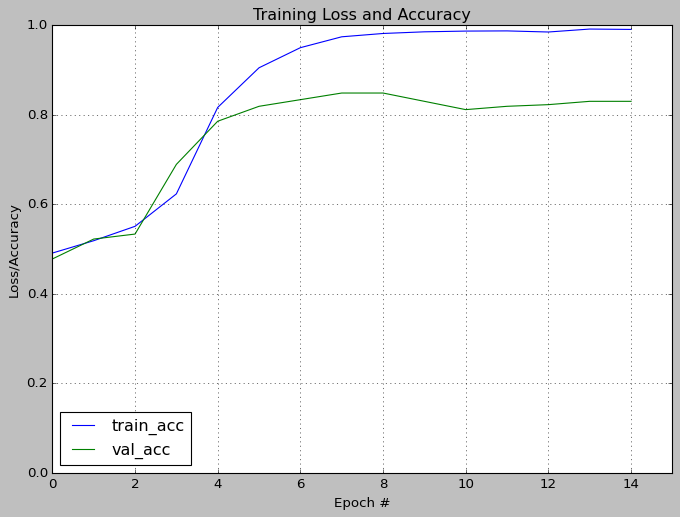

In [11]:
myRNN.test(X[0:1000],y[0:1000])
myRNN.test(X[1000:2000],y[1000:2000])
myRNN.test(X[2000:3000],y[2000:3000])
myRNN.test(x_train, y_train)
myRNN.test(x_test, y_test)
plot_loss(myRNN.history,15)

In [13]:
myBiLSTM = BiLstm(input_dim, input_length)
myBiLSTM.fit(x_train,y_train,validation_fraction,mybatch_size,10,verbose)
myBiLSTM.save_model(name)  

Epoch 1/10
10/10 [==============================] - 6s 266ms/step - loss: 0.6920 - accuracy: 0.5222 - val_loss: 0.6884 - val_accuracy: 0.5667
Epoch 2/10
10/10 [==============================] - 2s 167ms/step - loss: 0.6818 - accuracy: 0.5741 - val_loss: 0.6701 - val_accuracy: 0.6741
Epoch 3/10
10/10 [==============================] - 2s 173ms/step - loss: 0.6231 - accuracy: 0.7519 - val_loss: 0.5845 - val_accuracy: 0.7148
Epoch 4/10
10/10 [==============================] - 2s 173ms/step - loss: 0.4403 - accuracy: 0.8498 - val_loss: 0.6285 - val_accuracy: 0.6926
Epoch 5/10
10/10 [==============================] - 2s 172ms/step - loss: 0.2777 - accuracy: 0.8914 - val_loss: 0.4355 - val_accuracy: 0.7889
Epoch 6/10
10/10 [==============================] - 2s 165ms/step - loss: 0.1823 - accuracy: 0.9440 - val_loss: 0.3717 - val_accuracy: 0.8222
Epoch 7/10
10/10 [==============================] - 2s 171ms/step - loss: 0.1038 - accuracy: 0.9737 - val_loss: 0.4125 - val_accuracy: 0.8333
Epoch 

INFO:tensorflow:Assets written to: UIC-BiLSTM/assets


INFO:tensorflow:Assets written to: UIC-BiLSTM/assets


Accuracy of testing:  0.958
Accuracy of testing:  0.965
Accuracy of testing:  0.959
Accuracy of testing:  0.97962964
Accuracy of testing:  0.79


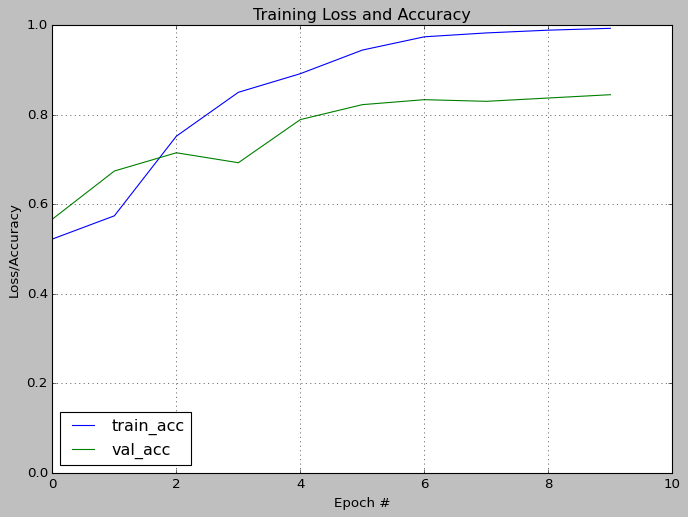

In [15]:
myBiLSTM.test(X[:1000], y[:1000])
myBiLSTM.test(X[1000:2000], y[1000:2000])
myBiLSTM.test(X[2000:3000], y[2000:3000])
myBiLSTM.test(x_train, y_train)
myBiLSTM.test(x_test, y_test)
plot_loss(myBiLSTM.history,10)

#**CONDUCTING THE EXPERIMENT WITH STANDFORD DATASET**

#GETTING DATASET:

In [16]:
name = "Standford"
if name == "Standford":
  mydata = get_prepocessed_dataset('drive/MyDrive/preprocessed_data/standford/processed_standford.pkl')[0]
  x_train = np.array(mydata[0]['input'])
  x_test = np.array(mydata[1]['input'])
  y_train = np.array(mydata[0]['output'])
  y_test = np.array(mydata[1]['output'])
  vocabulary_size = mydata[0]['word_count'][0]
  x_dev = np.array(mydata[2]['input'])
else: 
  mydata = get_prepocessed_dataset('drive/MyDrive/preprocessed_data/sentiment_sentences/processed_sentiment_sentences.pkl')[0] #it has only a row and 3 columns   
  X = np.array(mydata['input'])
  y = np.array(mydata['output'])
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  vocabulary_size = mydata['word_count'][0]

#DEFINE PARAMETERS

In [17]:
vocabulary_size = vocabulary_size + 1
seq_len = x_train.shape[1] #the cols or charater of each samples
input_dim = vocabulary_size 
input_length = seq_len
#print(input_dim,input_length)
validation_fraction = 0.1
mybatch_size = 256
#myepochs = 5
verbose = 1

#TRAINING MODEL

In [32]:
myRNN = RNN(input_dim, input_length)
myRNN.fit(x_train,y_train,validation_fraction,mybatch_size,15,verbose)
myRNN.save_model(name)

Epoch 1/15
88/88 [==============================] - 28s 281ms/step - loss: 0.6300 - accuracy: 0.6288 - val_loss: 0.4787 - val_accuracy: 0.8344
Epoch 2/15
88/88 [==============================] - 24s 268ms/step - loss: 0.3686 - accuracy: 0.8584 - val_loss: 0.4351 - val_accuracy: 0.7904
Epoch 3/15
88/88 [==============================] - 24s 271ms/step - loss: 0.2125 - accuracy: 0.9293 - val_loss: 0.4555 - val_accuracy: 0.7964
Epoch 4/15
88/88 [==============================] - 24s 272ms/step - loss: 0.1199 - accuracy: 0.9655 - val_loss: 0.7536 - val_accuracy: 0.7788
Epoch 5/15
88/88 [==============================] - 24s 271ms/step - loss: 0.0711 - accuracy: 0.9824 - val_loss: 0.8626 - val_accuracy: 0.7940
Epoch 6/15
88/88 [==============================] - 24s 272ms/step - loss: 0.0497 - accuracy: 0.9882 - val_loss: 0.8691 - val_accuracy: 0.7676
Epoch 7/15
88/88 [==============================] - 24s 271ms/step - loss: 0.0442 - accuracy: 0.9893 - val_loss: 0.9140 - val_accuracy: 0.7780

INFO:tensorflow:Assets written to: Standford-LSTM/assets


INFO:tensorflow:Assets written to: Standford-LSTM/assets


Accuracy of testing:  0.9754
Accuracy of testing:  0.76988


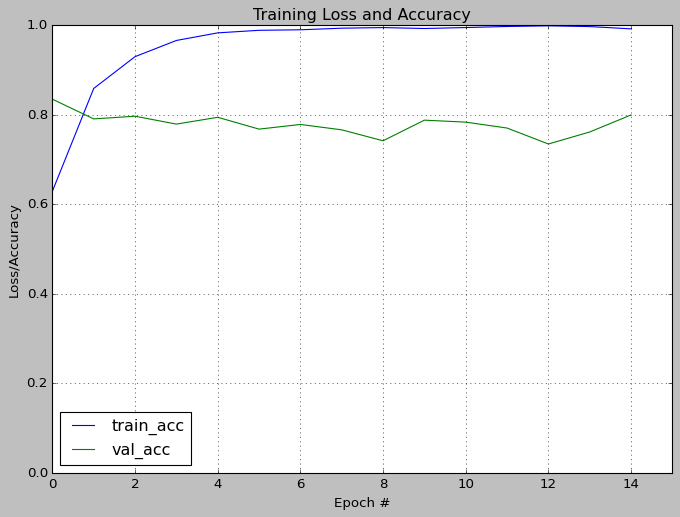

In [33]:
myRNN.test(x_train, y_train)
myRNN.test(x_test, y_test)
plot_loss(myRNN.history,15)

In [34]:
myBiLSTM = BiLstm(input_dim, input_length)
myBiLSTM.fit(x_train,y_train,validation_fraction,mybatch_size,10,verbose)
myBiLSTM.save_model(name)  

Epoch 1/10
88/88 [==============================] - 73s 788ms/step - loss: 0.5377 - accuracy: 0.7052 - val_loss: 0.3801 - val_accuracy: 0.8172
Epoch 2/10
88/88 [==============================] - 69s 788ms/step - loss: 0.2544 - accuracy: 0.8996 - val_loss: 0.4113 - val_accuracy: 0.8340
Epoch 3/10
88/88 [==============================] - 69s 781ms/step - loss: 0.1278 - accuracy: 0.9559 - val_loss: 0.4473 - val_accuracy: 0.8276
Epoch 4/10
88/88 [==============================] - 68s 772ms/step - loss: 0.0605 - accuracy: 0.9799 - val_loss: 0.7700 - val_accuracy: 0.7852
Epoch 5/10
88/88 [==============================] - 68s 772ms/step - loss: 0.0383 - accuracy: 0.9873 - val_loss: 1.1917 - val_accuracy: 0.7580
Epoch 6/10
88/88 [==============================] - 68s 771ms/step - loss: 0.0220 - accuracy: 0.9927 - val_loss: 0.9013 - val_accuracy: 0.8032
Epoch 7/10
88/88 [==============================] - 68s 769ms/step - loss: 0.0134 - accuracy: 0.9953 - val_loss: 1.2054 - val_accuracy: 0.7896

INFO:tensorflow:Assets written to: Standford-BiLSTM/assets


INFO:tensorflow:Assets written to: Standford-BiLSTM/assets


Accuracy of testing:  0.96876
Accuracy of testing:  0.7722


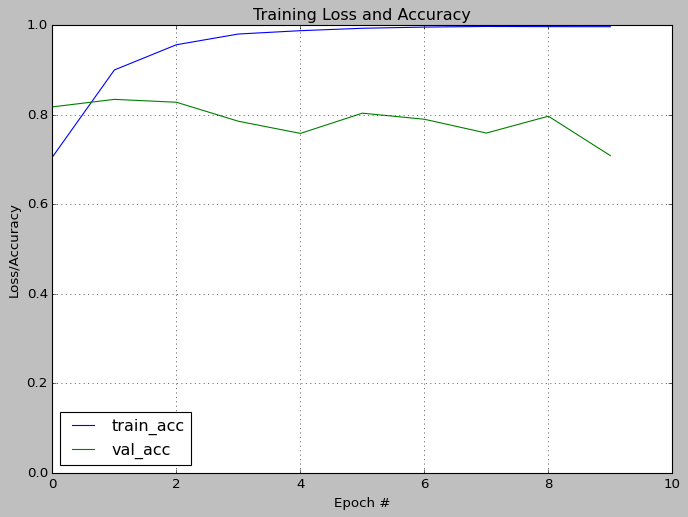

In [35]:
myBiLSTM.test(x_train, y_train)
myBiLSTM.test(x_test, y_test)
plot_loss(myBiLSTM.history,10)